# Brain MRI from Corona paper - Reconstruction+segmentation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.signal import filtfilt
from scipy.linalg import solve
from scipy.sparse.linalg import lsqr
from pylops.basicoperators import *
from pylops.basicoperators import VStack as VStacklop

from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *

from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *
from pyproximal.optimization.segmentation import Segment

In [2]:
def RRE(x, xinv):
    return np.linalg.norm(x-xinv) / np.linalg.norm(x)

def PSNR(x, xinv):
    return 10 * np.log10(len(xinv) * np.max(xinv) / np.linalg.norm(x-xinv))

In [3]:
mat=loadmat('/Users/matteoravasi/Desktop/Statoil/2020/Project/SegmentationPostStack/JointReconstructionSegmentation/JointRecSegm/brainphantom.mat')
mat1=loadmat('/Users/matteoravasi/Desktop/Statoil/2020/Project/SegmentationPostStack/JointReconstructionSegmentation/JointRecSegm/spiralsampling.mat')

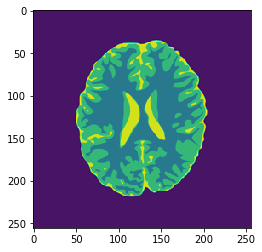

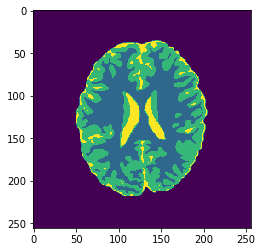

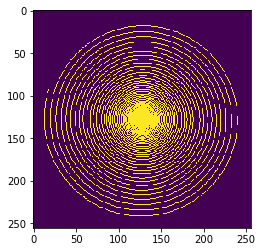

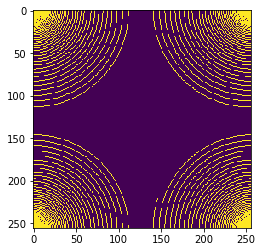

In [4]:
gt = mat['gt']
gt_seg = mat['gt_seg']
samp = mat1['samp']
samp1 = np.fft.ifftshift(samp)
sigman = 0.

plt.figure()
plt.imshow(gt)

plt.figure()
plt.imshow(gt_seg)

plt.figure()
plt.imshow(samp)

plt.figure()
plt.imshow(samp1);

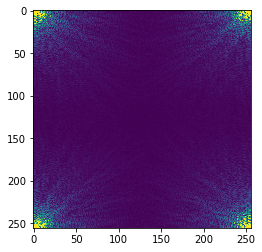

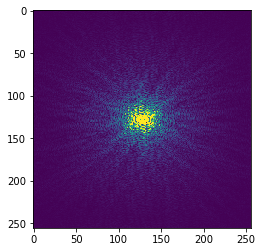

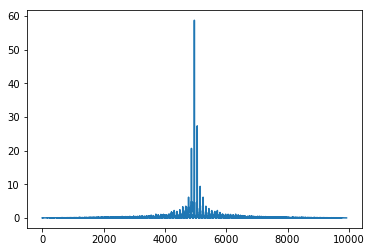

In [5]:
Fop = FFT2D(dims=gt.shape)
Rop = Restriction(gt.size, np.where(samp1.ravel() == 1)[0], dtype=np.complex)
Dop = Rop * Fop

GT = Fop * gt.ravel()
GT = GT.reshape(gt.shape)
d = Dop * gt.ravel()
d += np.random.normal(0, sigman, d.shape)

plt.figure()
plt.imshow(np.abs(GT), vmin=0, vmax=1)

plt.figure()
plt.imshow(np.fft.fftshift(np.abs(GT)), vmin=0, vmax=1)

plt.figure()
plt.plot(np.fft.fftshift(np.abs(d)))

## Zero filling reconstruction

RRE= 0.1410590666390702
PSNR= 37.15535506534759


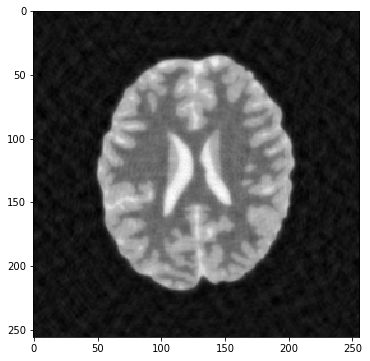

In [6]:
GTzero = samp1 * GT

gtzero = Fop.H * GTzero.ravel()
gtzero = np.real(gtzero.reshape(gt.shape))

print('RRE=', RRE(gt.ravel(), gtzero.ravel()))
print('PSNR=', PSNR(gt.ravel(), gtzero.ravel()))

plt.figure(figsize=(6, 6))
plt.imshow(gtzero, 'gray')

## TV regularized reconstruction

8.750446417183525 8.750446417183525
Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.LinearOperator.LinearOperator'>
Additional vector (z): None
tau = 8.750446e+00	mu = 8.750446e+00
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   4.16746e-02   4.132e+01   5.643e+01   0.000e+00       9.775e+01
     2   4.07823e-02   5.185e-01   6.082e+01   0.000e+00       6.134e+01
     3   3.45600e-02   1.293e-01   6.055e+01   0.000e+00       6.068e+01
     4   2.82259e-02   2.128e-01   5.990e+01   0.000e+00       6.011e+01
     5   2.31727e-02   3.271e-01   5.924e+01   0.000e+00       5.956e+01
     6   1.98898e-02   4.624e-01   5.861e+01   0.000e+00       5.907e+01
     7   1.83837e-02   6.164e-01   5.800e+01   0.000e+00       5.862e+01

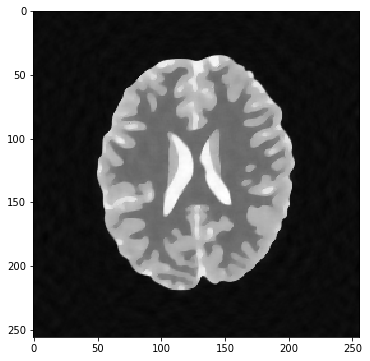

In [7]:
sigma = 0.04
l1 = L21(ndim=2)
l2 = L2(Op=Dop, b=d.ravel(), niter=50, warm=True)
Gop = sigma * Gradient(dims=gt.shape, edge=True, kind='forward', dtype=np.complex)

L = sigma**2*8
tau = .99 / np.sqrt(L)
mu = .99 / np.sqrt(L)
print(tau, mu)

gt_pd = PrimalDual(l2, l1, Gop, x0=np.zeros(gt.size), tau=tau, mu=mu, theta=1., niter=100, show=True)
gt_pd = np.real(gt_pd.reshape(gt.shape))

print('RRE=', RRE(gt.ravel(), gt_pd.ravel()))
print('PSNR=', PSNR(gt.ravel(), gt_pd.ravel()))

plt.figure(figsize=(6, 6))
plt.imshow(gt_pd, 'gray');

Same but with sigma in L21 (not directly on Gop)

0.350017856687341 0.350017856687341
RRE= 0.15107516250404254
PSNR= 36.62903327076269


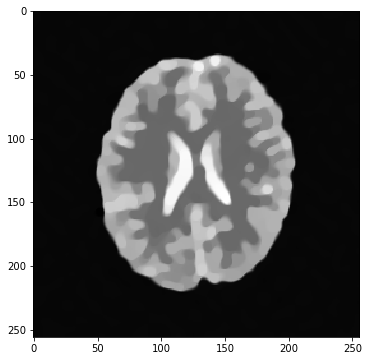

In [8]:
sigma = 0.04
l1 = L21(ndim=2, sigma=sigma)
l2 = L2(Op=Dop, b=d.ravel(), niter=50, warm=True)
Gop = Gradient(dims=gt.shape, edge=True, kind='forward')

L = 8
tau = .99 / np.sqrt(L)
mu = .99 / np.sqrt(L)
print(tau, mu)

gt_pd = PrimalDual(l2, l1, Gop, x0=np.zeros(gt.size), tau=tau, mu=mu, theta=1., niter=100)
gt_pd = np.real(gt_pd.reshape(gt.shape))

print('RRE=', RRE(gt.ravel(), gt_pd.ravel()))
print('PSNR=', PSNR(gt.ravel(), gt_pd.ravel()))

plt.figure(figsize=(6, 6))
plt.imshow(gt_pd, 'gray');

Now we use a specialized operator for the data term as the modelling operator of this problem is a concatenation of a 2D FFT and a Sampling matrix

In [9]:
class L2MRI(ProxOperator):
    """Specialized L2 norm with MRI modelling operator (Op = S * F)"""
    def __init__(self, Sop, Fop, b=None):
        super().__init__(None, True)
        self.Sop = Sop
        self.Fop = Fop
        self.Op = Sop * Fop
        self.diagS = np.zeros(Sop.M)
        self.diagS[Sop.iava] = 1
        self.b = b
        # create data term
        self.SopTb = self.Sop.rmatvec(self.b)
    
    def __call__(self, x):
        if self.Op is not None and self.b is not None:
            f = np.linalg.norm(self.Op * x - self.b) ** 2
        return f
    
    def prox(self, x, tau):
        y = self.Fop.rmatvec((self.Fop.matvec(x) + tau * self.SopTb) / (1 + tau * self.diagS))
        return y
    
    def grad(self, x):
        g = self.Op.rmatvec(self.Op.matvec(x) - self.b)
        return g

0.350017856687341 0.350017856687341
Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class '__main__.L2MRI'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Additional vector (z): None
tau = 3.500179e-01	mu = 3.500179e-01
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   1.20397e-02   4.311e+03   1.630e+01   0.000e+00       4.327e+03
     2   2.01297e-02   2.374e+03   2.569e+01   0.000e+00       2.400e+03
     3   2.53779e-02   1.316e+03   3.099e+01   0.000e+00       1.347e+03
     4   2.89123e-02   7.363e+02   3.396e+01   0.000e+00       7.702e+02
     5   3.17298e-02   4.187e+02   3.566e+01   0.000e+00       4.544e+02
     6   3.43249e-02   2.443e+02   3.680e+01   0.000e+00       2.811e+02
     7   3.68311e-02   1.482e+02   3.773e+01   0.000e+00       1.859e+02
     8   3.

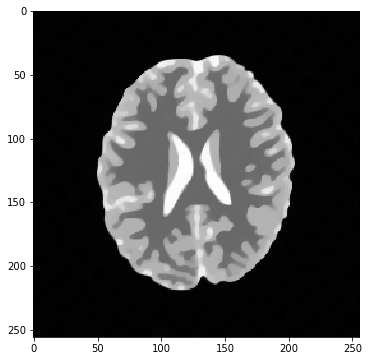

In [10]:
sigma = 0.04
l1 = L21(ndim=2, sigma=sigma)
l2 = L2MRI(Rop, Fop, b=d.ravel())
Gop = Gradient(dims=gt.shape, edge=True, kind='forward', dtype=np.complex)

L = 8
tau = .99 / np.sqrt(L)
mu = .99 / np.sqrt(L)
print(tau, mu)

gt_pd1 = PrimalDual(l2, l1, Gop, x0=np.zeros(gt.size), tau=tau, mu=mu, theta=1., niter=100, show=True)
gt_pd1 = np.real(gt_pd1.reshape(gt.shape))

print('RRE=', RRE(gt.ravel(), gt_pd1.ravel()))
print('PSNR=', PSNR(gt.ravel(), gt_pd1.ravel()))

plt.figure(figsize=(6, 6))
plt.imshow(gt_pd1, 'gray');

Same but with adaptive Primal-dual

Adaptive Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class '__main__.L2MRI'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Additional vector (z): None
tau0 = 3.500179e-01	mu0 = 3.500179e-01
alpha0 = 5.000000e-01	eta = 9.500000e-01
s = 1.000000e+00	delta = 1.500000e+00
niter = 20		tol = 1.000000e-10

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   1.20397e-02   4.311e+03   1.630e+01   0.000e+00       4.327e+03
     2   2.42390e-02   1.503e+03   3.131e+01   0.000e+00       1.535e+03
     3   3.00248e-02   2.906e+02   4.120e+01   0.000e+00       3.318e+02
     4   2.67433e-02   3.781e+01   4.599e+01   0.000e+00       8.379e+01
     5   2.48160e-02   1.748e+01   4.780e+01   0.000e+00       6.528e+01
     6   2.52109e-02   1.453e+01   4.794e+01   0.000e+00       6.246e+01
     7   2.69980e-02   1.

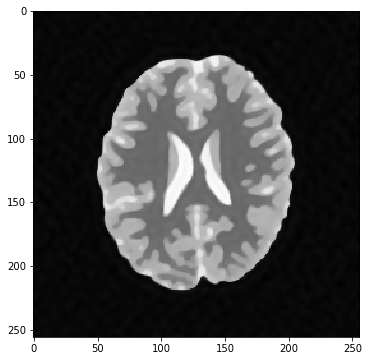

In [11]:
gt_apd, steps = AdaptivePrimalDual(l2, l1, Gop, x0=np.zeros(gt.size), tau=tau, mu=mu, niter=20, s=1., show=True)
gt_apd = np.real(gt_apd.reshape(gt.shape))

print('RRE=', RRE(gt.ravel(), gt_apd.ravel()))
print('PSNR=', PSNR(gt.ravel(), gt_apd.ravel()))

plt.figure(figsize=(6, 6))
plt.imshow(gt_apd, 'gray');

## Segmentation

In [12]:
cl = np.array([0.01, 0.43, 0.65, 0.8])
ncl = len(cl)

segpd, segpd_classes = Segment(gt_pd1, cl, 1., 0.001, 
                               niter=10, show=True)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.Simplex._Simplex'>
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
Linear operator (A): <class 'pylops.basicoperators.BlockDiag.BlockDiag'>
Additional vector (z): vector
tau = 1.000000e+00	mu = 1.250000e-01
theta = 1.00		niter = 10

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   3.82902e-01   1.000e+00   5.338e-01   4.609e+03       4.610e+03
     2   5.00578e-01   1.000e+00   8.254e-01   2.782e+03       2.784e+03
     3   5.84103e-01   1.000e+00   9.882e-01   2.027e+03       2.029e+03
     4   6.42851e-01   1.000e+00   1.127e+00   1.553e+03       1.555e+03
     5   6.78456e-01   1.000e+00   1.262e+00   1.391e+03       1.393e+03
     6   7.14015e-01   1.000e+00   1.390e+00   1.238e+03       1.240e+03
     7   7.49539e-01   1.000e+00   1.516e+00   1.090e+03       1.092e+03
     8   7.8

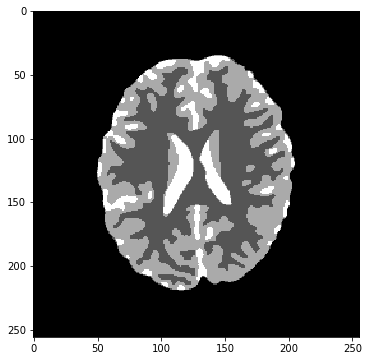

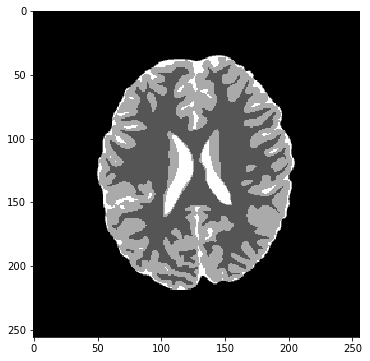

In [13]:
plt.figure(figsize=(6, 6))
plt.imshow(segpd_classes, 'gray')

plt.figure(figsize=(6, 6))
plt.imshow(gt_seg, 'gray')

## TV regularized reconstruction with Bregman iterations

In [14]:
def callback(x, xhist):
    xhist.append(x)

0.350017856687341 0.350017856687341
Bregman
---------------------------------------------------------
Proximal operator (f): <class '__main__.L2MRI'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Inner Solver: <function PrimalDual at 0x1a19af7378>
alpha = 1.000000e+00	tolf = 0.000000e+00	tolx = 1.000000e-02
niter = 7

   Itn       x[0]          f           g       J = f + g
     1   4.93374e-02   3.904e+02   4.203e+02   8.106e+02
     2   4.83383e-02   1.552e+02   6.484e+02   8.036e+02
     3   5.11775e-02   9.582e+01   7.664e+02   8.622e+02
     4   4.91158e-02   6.806e+01   8.492e+02   9.172e+02
     5   5.35547e-02   5.040e+01   9.157e+02   9.661e+02
     6   5.11843e-02   3.901e+01   9.732e+02   1.012e+03
     7   5.05233e-02   3.210e+01   1.018e+03   1.050e+03

Total time (s) = 28.13
---------------------------------------------------------



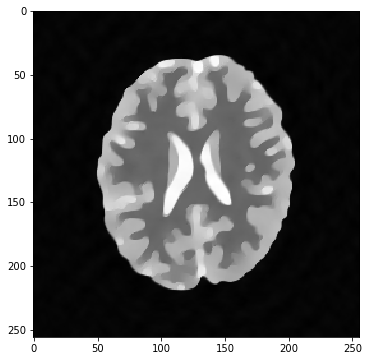

In [15]:
# L2 data term
l1 = L21(ndim=2)
#l2 = L2(Op=Dop, b=d.ravel(), niter=50, warm=True)
l2 = L2MRI(Rop, Fop, b=d.ravel()) # need to make grad!
Gop = Gradient(dims=gt.shape, edge=True, kind='forward', dtype=np.complex)

L = 8
tau = .99 / np.sqrt(L)
mu = .99 / np.sqrt(L)
print(tau, mu)

sigma = 1.
gt_breg_hist = []
gt_breg = Bregman(l2, l1, x0=np.zeros(gt.size),
                  solver=PrimalDual, A=Gop, alpha=sigma, tolx=1e-2, tolf=len(d) * sigman**2,
                  niterouter=7, show=True, bregcallback=lambda x: callback(x, gt_breg_hist),
                  **dict(tau=tau, mu=mu, theta=1., niter=100))
gt_breg = np.real(gt_breg.reshape(gt.shape))

plt.figure(figsize=(6, 6))
plt.imshow(gt_breg, 'gray');

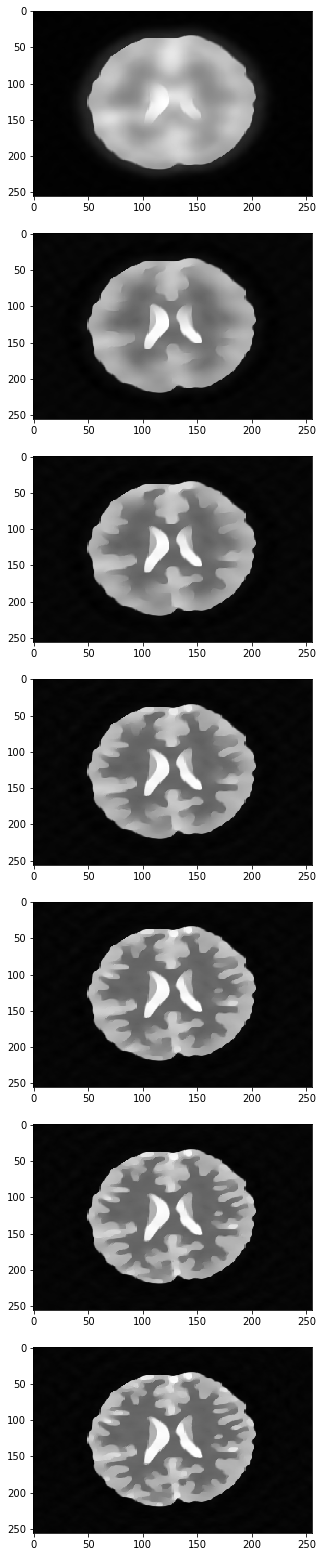

In [16]:
fig, axs = plt.subplots(len(gt_breg_hist), 1, figsize=(5, 4*len(gt_breg_hist)))
for i, gt_breg_h in enumerate(gt_breg_hist):
    gt_breg_h = np.real(gt_breg_h.reshape(gt.shape))
    axs[i].imshow(gt_breg_h, 'gray')
    axs[i].axis('tight')

Bregman
---------------------------------------------------------
Proximal operator (f): <class '__main__.L2MRI'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Inner Solver: <function AdaptivePrimalDual at 0x1a19af7400>
alpha = 1.000000e+00	tolf = 0.000000e+00	tolx = 1.000000e-02
niter = 7

   Itn       x[0]          f           g       J = f + g
     1   3.95328e-02   3.841e+02   5.505e+02   9.346e+02
     2   3.81307e-02   1.470e+02   7.798e+02   9.268e+02
     3   3.64330e-02   9.497e+01   8.960e+02   9.910e+02
     4   2.96257e-02   7.997e+01   9.700e+02   1.050e+03
     5   2.38351e-02   6.036e+01   1.053e+03   1.113e+03
     6   3.25213e-02   4.796e+01   1.127e+03   1.174e+03
     7   3.88027e-02   3.915e+01   1.208e+03   1.247e+03

Total time (s) = 10.13
---------------------------------------------------------



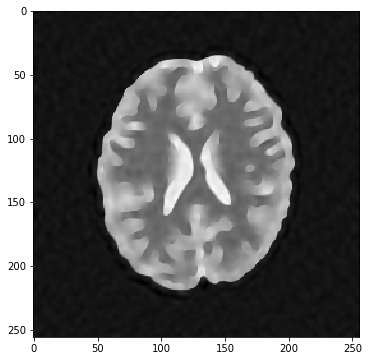

In [17]:
sigma = 1.
gt_abreg_hist = []
gt_abreg = Bregman(l2, l1, x0=np.zeros(gt.size),
                  solver=AdaptivePrimalDual, A=Gop, alpha=sigma, tolx=1e-2, tolf=len(d) * sigman**2,
                  niterouter=7, show=True, bregcallback=lambda x: callback(x, gt_abreg_hist),
                  **dict(tau=tau, mu=mu, niter=30))
gt_abreg = np.real(gt_abreg.reshape(gt.shape))

plt.figure(figsize=(6, 6))
plt.imshow(gt_abreg, 'gray');

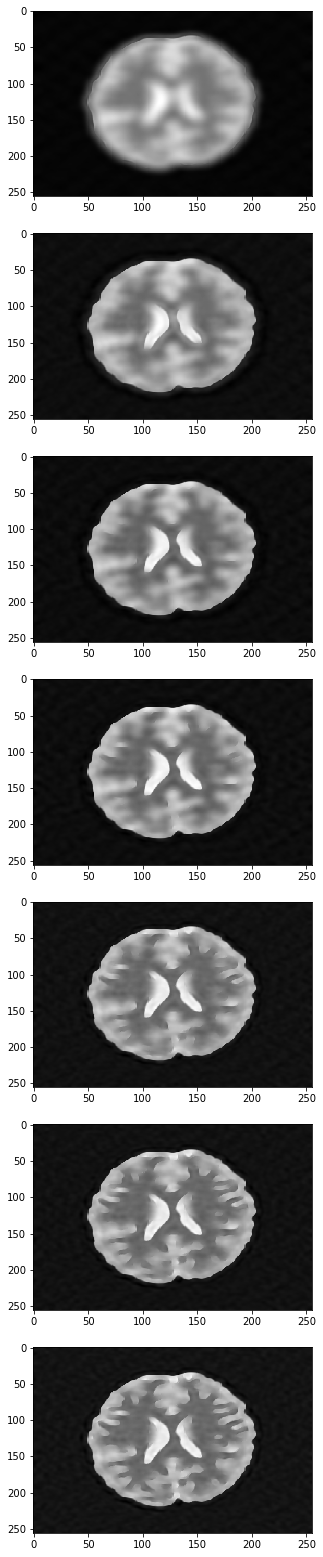

In [18]:
fig, axs = plt.subplots(len(gt_breg_hist), 1, figsize=(5, 4*len(gt_breg_hist)))
for i, gt_abreg_h in enumerate(gt_abreg_hist):
    gt_abreg_h = np.real(gt_abreg_h.reshape(gt.shape))
    axs[i].imshow(gt_abreg_h, 'gray')
    axs[i].axis('tight')

## Segmentation on Bregman result

In [19]:
cl = np.array([0.01, 0.43, 0.65, 0.8])
ncl = len(cl)

segpd, segpd_classes = Segment(gt_breg, cl, 1., 0.001, 
                               niter=10, show=True)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.Simplex._Simplex'>
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
Linear operator (A): <class 'pylops.basicoperators.BlockDiag.BlockDiag'>
Additional vector (z): vector
tau = 1.000000e+00	mu = 1.250000e-01
theta = 1.00		niter = 10

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   3.82518e-01   1.000e+00   5.249e-01   4.617e+03       4.619e+03
     2   5.00240e-01   1.000e+00   8.136e-01   2.792e+03       2.794e+03
     3   5.84057e-01   1.000e+00   9.902e-01   2.032e+03       2.034e+03
     4   6.43154e-01   1.000e+00   1.117e+00   1.560e+03       1.562e+03
     5   6.79256e-01   1.000e+00   1.255e+00   1.398e+03       1.401e+03
     6   7.15390e-01   1.000e+00   1.382e+00   1.245e+03       1.248e+03
     7   7.51584e-01   1.000e+00   1.506e+00   1.096e+03       1.098e+03
     8   7.8

In [20]:
segpd1, segpd1_classes = Segment(gt_breg, cl, 1., .1, niter=10, show=True)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.Simplex._Simplex'>
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
Linear operator (A): <class 'pylops.basicoperators.BlockDiag.BlockDiag'>
Additional vector (z): vector
tau = 1.000000e+00	mu = 1.250000e-01
theta = 1.00		niter = 10

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   3.82518e-01   1.000e+00   5.249e+01   4.617e+03       4.671e+03
     2   5.00240e-01   1.000e+00   7.967e+01   2.798e+03       2.878e+03
     3   5.84057e-01   1.000e+00   9.519e+01   2.040e+03       2.136e+03
     4   6.43173e-01   1.000e+00   1.055e+02   1.573e+03       1.679e+03
     5   6.79299e-01   1.000e+00   1.160e+02   1.416e+03       1.533e+03
     6   7.15500e-01   1.000e+00   1.245e+02   1.270e+03       1.395e+03
     7   7.51788e-01   1.000e+00   1.318e+02   1.129e+03       1.262e+03
     8   7.8

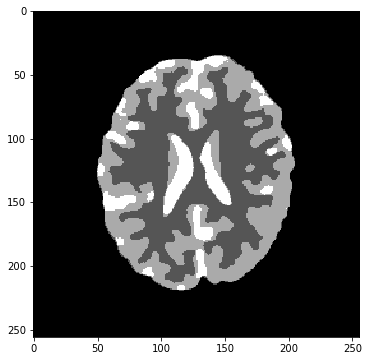

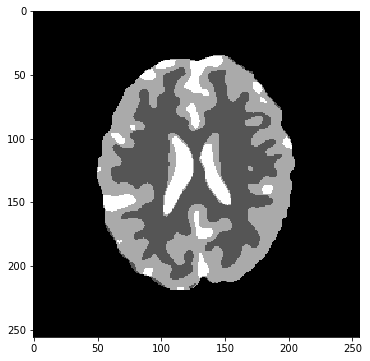

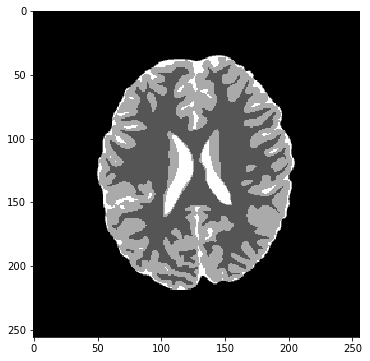

In [21]:
plt.figure(figsize=(6, 6))
plt.imshow(segpd_classes, 'gray')

plt.figure(figsize=(6, 6))
plt.imshow(segpd1_classes, 'gray')

plt.figure(figsize=(6, 6))
plt.imshow(gt_seg, 'gray')

## Joint Reconstruction-Segmentation

**Inversion**

$$
m^{k+1} = min_x  (\frac{1}{2}||Ax-f||_2^2 + \delta ||\hat{V}x-\hat{c}||_2^2 - \alpha p^{kT}x) + \alpha ||Dx||_{2,1} 
$$

combining the first two terms

$$
m^{k+1} = min_x  (\frac{1}{2}||A^1x-f^1||_2^2 - \alpha p^{kT}x) + \alpha ||Dx||_{2,1} 
$$

where $A^1 = [A, \sqrt{2\delta}\hat{V}]^T$ and $f^1 = [f, \sqrt{2\delta}\hat{c}]^T$ and $\hat{V}=[diag(\sqrt{v_1}), ..., diag(\sqrt{v_N})]$ and $\hat{c}=[\sqrt{v_1}c_1, ..., \sqrt{v_N}c_N]$


**Segmentation**


$$
v^{k+1} = min_{v \in C}  (v^T(\delta g - \beta q^k) - \alpha p^{kT}x) + \alpha ||Dx||_{2,1} 
$$

where $C$ is a simplex.

Let's first check that $\delta  \frac{\delta ||\hat{V}x-\hat{c}||_2^2}{\delta x} = 2 \delta  \hat{V}^H (\hat{V}x-\hat{c}) = 2 \sum_j v_j(x-c_j) = 2 \delta  x \sum_j v_j - 2 \delta  \sum_j v_j c_j$

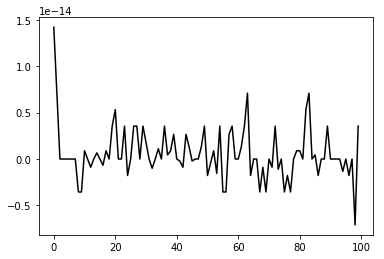

In [22]:
delta = 10.
cl = np.array([0.01, 0.43, 0.65, 0.8])
ncl = len(cl)

nx = 100
x = np.random.normal(0., 1., nx)
v = np.abs(np.random.normal(0., 1., (ncl, nx)))
v = v / np.sum(v, axis=0)
V = np.hstack([np.diag(np.sqrt(v[i])) for i in range(ncl)]).T
cc = (np.sqrt(v) * cl[:, np.newaxis]).ravel()
grad = 2 * delta * V.T @ (V @ x - cc)

vv = np.sum(v, axis=0)
vc = np.sum(v * cl[:, np.newaxis], axis=0)

grad1 = 2 * delta * x * vv - 2 * delta * vc

plt.plot(grad-grad1, 'k');

Iteration 0...
f= 163.85903219157242
||v-v_old||_2= 128.33356654580797
||m-m_old||_2= 83.81459928010864
RRE= 0.24296009558765883
PSNR= 33.68866171367628
Iteration 1...
f= 64.62629647253394
||v-v_old||_2= 9.60299346748262
||m-m_old||_2= 11.687174304715139
RRE= 0.17406800531268832
PSNR= 35.90669088129883
Iteration 2...
f= 39.77587389457887
||v-v_old||_2= 9.70217144419924
||m-m_old||_2= 5.300060935098155
RRE= 0.14825324807762733
PSNR= 36.641688850883256
Iteration 3...
f= 27.24917974706836
||v-v_old||_2= 9.749310343363135
||m-m_old||_2= 3.666792021936153
RRE= 0.13133647265932835
PSNR= 37.17587102152018
Iteration 4...
f= 20.27004351217884
||v-v_old||_2= 9.769962793727448
||m-m_old||_2= 2.7728351118946186
RRE= 0.1193794287618895
PSNR= 37.601165235515396
Iteration 5...
f= 16.003926332983603
||v-v_old||_2= 9.619627406608457
||m-m_old||_2= 2.0531836301402495
RRE= 0.11038721422476304
PSNR= 37.94810488556195
Iteration 6...
f= 12.978263069066125
||v-v_old||_2= 9.540532272015012
||m-m_old||_2= 1.68

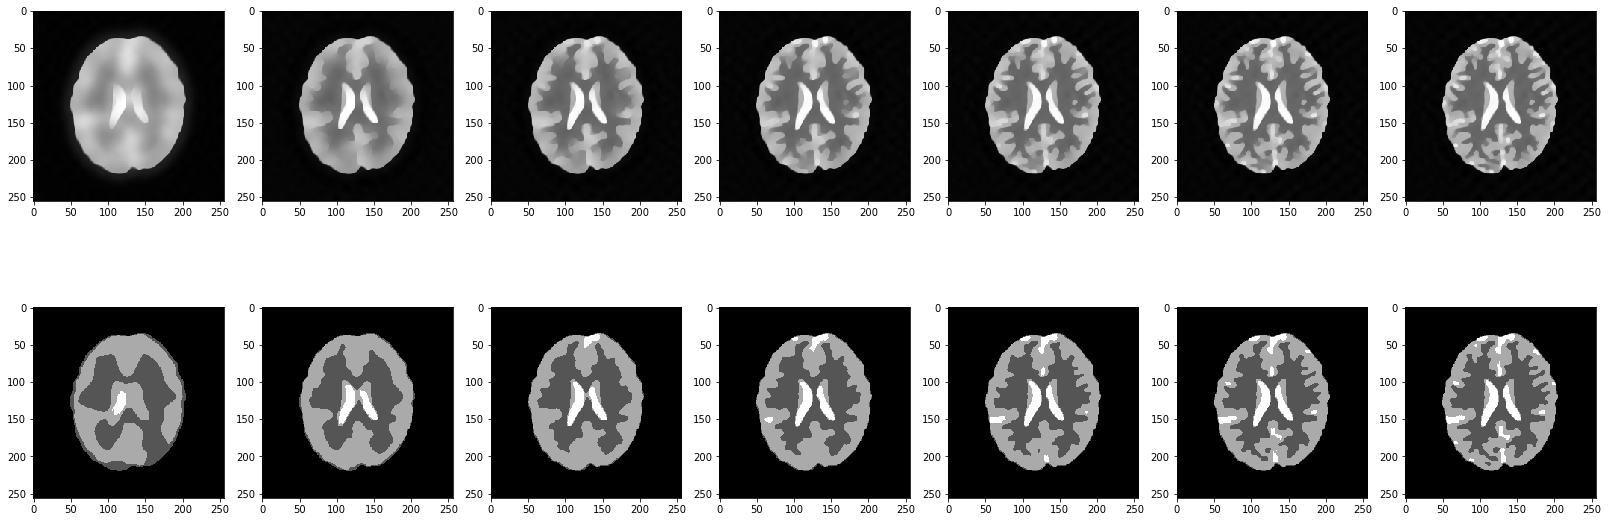

In [23]:
# regularization knobs
alpha = 0.8
beta = 0.001
delta = 0.01

niter = 7
tolstop = 0.

# TV regularization term
Gop = Gradient(dims=gt.shape, edge=True, kind='forward', dtype=np.complex)
l1_m = L21(ndim=2, sigma=alpha)

fig, axs = plt.subplots(2, niter, figsize=(4*niter, 10))
p = np.zeros_like(gt).ravel()
q = np.zeros(ncl*gt.size)
v = np.zeros(ncl*gt.size)
gt_joint = np.zeros_like(gt).ravel()
rre = np.zeros(niter)
psnr = np.zeros(niter)
for iiter in range(niter):
    print('Iteration %d...' % iiter)
    gt_jointold = gt_joint.copy()
    vold = v.copy()
    
    #############
    # Inversion #  
    #############
    if iiter == 0:
        # define misfit term
        l2 = L2(Op=Dop, b=d.ravel(), niter=50, warm=True)

        # steps
        L = 8
        tau = .99 / np.sqrt(L)
        mu = .99 / np.sqrt(L)
        
        gt_joint = PrimalDual(l2, l1_m, Gop, x0=np.zeros_like(gt_joint), 
                              tau=tau, mu=mu, theta=1., niter=100)
        gt_joint = np.real(gt_joint)

        # Update p
        l2_grad = L2(Op=Dop, b=d.ravel())
        dp = (1./alpha) * l2_grad.grad(gt_joint)
        p -= np.real(dp)        
    else:
        v = v.reshape((gt.size, ncl))
        
        # define misfit term
        L1op = VStacklop([Dop] + [Diagonal(np.sqrt(2.*delta)*np.sqrt(v[:, icl])) for icl in range(ncl)])
        d1 = np.hstack([d.ravel(), (np.sqrt(2.*delta)*(np.sqrt(v) * cl[np.newaxis, :]).T).ravel()])
        l2 = L2(Op=L1op, b=d1, niter=50, warm=True, q=p, alpha=-alpha)

        # steps
        L = 8
        tau = .99 / np.sqrt(L)
        mu = .99 / np.sqrt(L)

        # solve
        gt_joint = PrimalDual(l2, l1_m, Gop, 
                              x0=np.zeros_like(gt_joint), #x0=gt_joint, 
                              tau=tau, mu=mu, theta=1., niter=100)
        gt_joint = np.real(gt_joint)

        # Update p
        l2_grad = L2(Op=L1op, b=d1)
        dp = (1./alpha) * l2_grad.grad(gt_joint)
        #dp = (1./alpha) * (Lop.H * (Dop * gt_joint.ravel() - d.ravel()) - 
        #                   2* delta * np.sum([v[:, icl] * (minv.ravel() - cl[icl]) 
        #                   for icl in range(ncl)]))
        p -= np.real(dp)
    
    axs[0, iiter].imshow(gt_joint.reshape(gt.shape), 'gray')
    
    ################
    # Segmentation #  
    ################
    v, vcl = Segment(gt_joint, cl, 2 * delta, 2 * beta, z=-beta*q, 
                     niter=10, callback=None, show=False,
                     kwargs_simplex=dict(engine='numba', maxiter=30))

    # Update q
    dq = (delta/beta) * ((gt_joint.ravel() - cl[:, np.newaxis]) ** 2).ravel()
    q -= dq
    
    axs[1, iiter].imshow(vcl.reshape(gt.shape), 'gray')

    # Monitor cost functions
    print('f=', L2(Op=Dop, b=d.ravel())(gt_joint))
    print('||v-v_old||_2=', np.linalg.norm(v.ravel() - vold.ravel()))
    print('||m-m_old||_2=', np.linalg.norm(gt_joint.ravel() - gt_jointold.ravel()))
        
    # Monitor quality of reconstruction
    rre[iiter] =RRE(gt.ravel(), gt_joint.ravel())
    psnr[iiter] = PSNR(gt.ravel(), gt_joint.ravel())
    print('RRE=', rre[iiter])
    print('PSNR=', psnr[iiter])
    
    # Check stopping criterion 
    if np.linalg.norm(v.ravel() - vold.ravel()) < tolstop:
        break

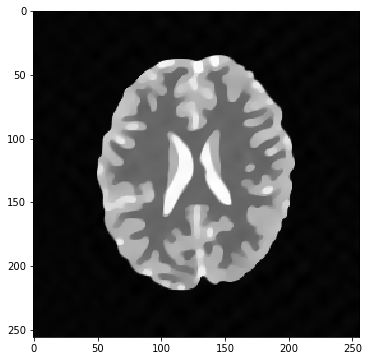

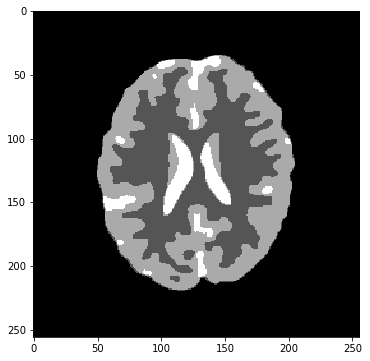

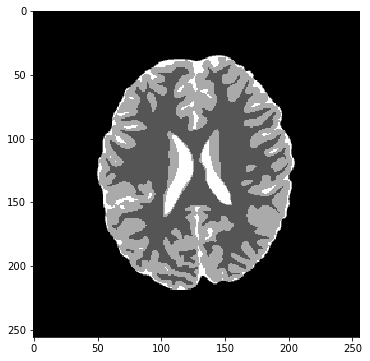

In [24]:
gt_joint = np.real(gt_joint.reshape(gt.shape))
vcl = np.real(vcl.reshape(gt.shape))

plt.figure(figsize=(6, 6))
plt.imshow(gt_joint, 'gray')

plt.figure(figsize=(6, 6))
plt.imshow(vcl, 'gray')

plt.figure(figsize=(6, 6))
plt.imshow(gt_seg, 'gray');

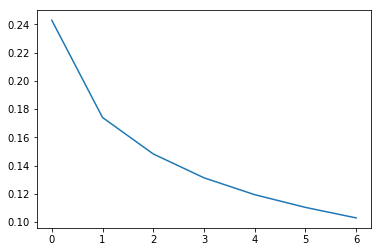

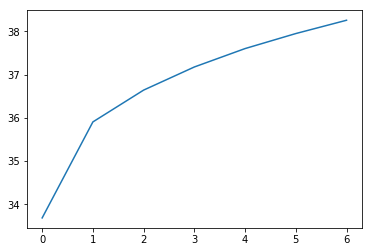

In [25]:
plt.figure()
plt.plot(rre)

plt.figure()
plt.plot(psnr)

Finally we use the Adaptive Primal-dual algorithm

Iteration 0...
f= 143.84147897900766
||v-v_old||_2= 128.34548747149628
||m-m_old||_2= 85.10733768726062
RRE= 0.2522139444146538
PSNR= 34.195859385733954
Iteration 1...
f= 68.98478547193118
||v-v_old||_2= 9.520742972243436
||m-m_old||_2= 10.599211156430755
RRE= 0.1955984770057841
PSNR= 35.62672136777931
Iteration 2...
f= 62.65120281004341
||v-v_old||_2= 9.677640347331794
||m-m_old||_2= 5.617862888478253
RRE= 0.1936684538652567
PSNR= 35.79760827110696
Iteration 3...
f= 58.82658066046065
||v-v_old||_2= 9.736513626544319
||m-m_old||_2= 4.04490547680891
RRE= 0.1945245957233137
PSNR= 35.773298355247675
Iteration 4...
f= 53.442471415866954
||v-v_old||_2= 9.750978269753505
||m-m_old||_2= 4.3458745261665905
RRE= 0.19096104369190173
PSNR= 35.875164088125715
Iteration 5...
f= 83.47798565784214
||v-v_old||_2= 9.677594699866932
||m-m_old||_2= 7.388271328714571
RRE= 0.21861586513846004
PSNR= 35.52958573186237
Iteration 6...
f= 77.704683190477
||v-v_old||_2= 9.5720636541676
||m-m_old||_2= 4.870768222

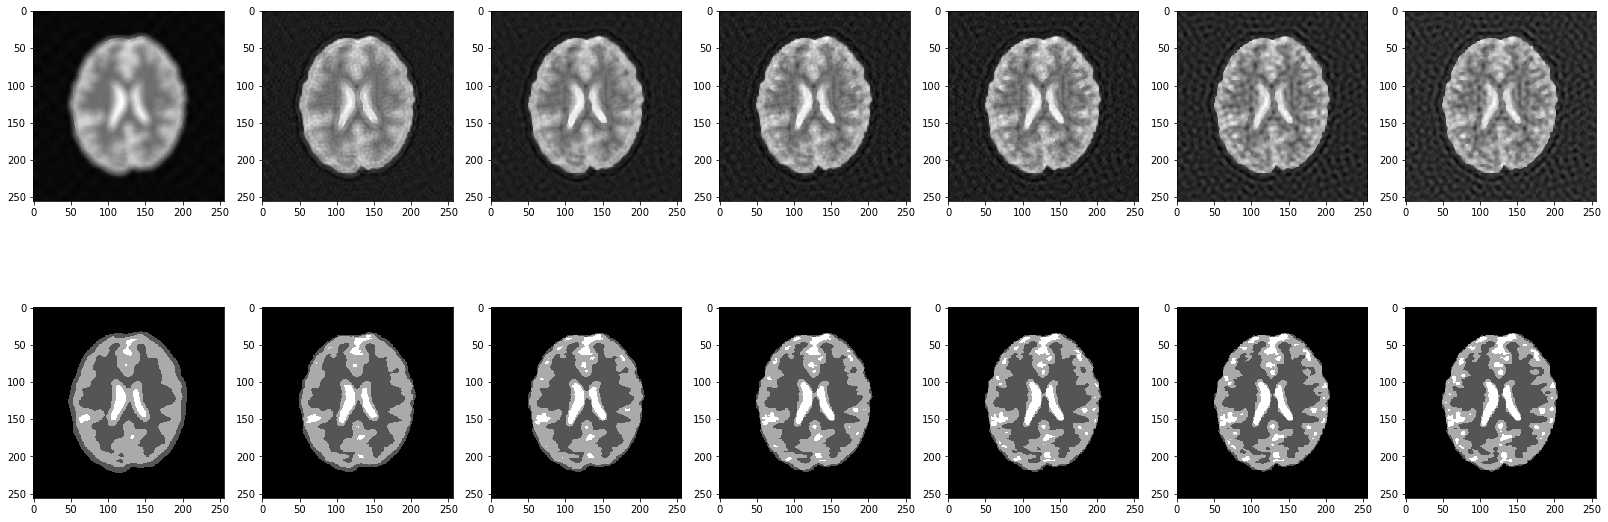

In [26]:
# regularization knobs
alpha = 0.8
beta = 0.001
delta = 0.01

niter = 7
tolstop = 0.

# TV regularization term
Gop = Gradient(dims=gt.shape, edge=True, kind='forward', dtype=np.complex)
l1_m = L21(ndim=2, sigma=alpha)

fig, axs = plt.subplots(2, niter, figsize=(4*niter, 10))
p = np.zeros_like(gt).ravel()
q = np.zeros(ncl*gt.size)
v = np.zeros(ncl*gt.size)
gt_joint = np.zeros_like(gt).ravel()
rre = np.zeros(niter)
psnr = np.zeros(niter)
for iiter in range(niter):
    print('Iteration %d...' % iiter)
    gt_jointold = gt_joint.copy()
    vold = v.copy()
    
    #############
    # Inversion #  
    #############
    if iiter == 0:
        # define misfit term
        l2 = L2(Op=Dop, b=d.ravel(), niter=50, warm=True)

        # steps
        L = 8
        tau = .95 / np.sqrt(L)
        mu = .95 / np.sqrt(L)
        
        gt_joint = AdaptivePrimalDual(l2, l1_m, Gop, x0=np.zeros_like(gt_joint), 
                                      tau=tau, mu=mu, niter=20)[0]
        gt_joint = np.real(gt_joint)

        # Update p
        l2_grad = L2(Op=Dop, b=d.ravel())
        dp = (1./alpha) * l2_grad.grad(gt_joint)
        p -= np.real(dp)        
    else:
        v = v.reshape((gt.size, ncl))
        
        # define misfit term
        L1op = VStacklop([Dop] + [Diagonal(np.sqrt(2.*delta)*np.sqrt(v[:, icl])) for icl in range(ncl)])
        d1 = np.hstack([d.ravel(), (np.sqrt(2.*delta)*(np.sqrt(v) * cl[np.newaxis, :]).T).ravel()])
        l2 = L2(Op=L1op, b=d1, niter=50, warm=True, q=p, alpha=-alpha)

        # steps
        L = 8
        tau = .95 / np.sqrt(L)
        mu = .95 / np.sqrt(L)

        # solve
        gt_joint = AdaptivePrimalDual(l2, l1_m, Gop, 
                                      x0=gt_joint, 
                                      tau=tau, mu=mu, niter=20)[0]
        gt_joint = np.real(gt_joint)

        # Update p
        l2_grad = L2(Op=L1op, b=d1)
        dp = (1./alpha) * l2_grad.grad(gt_joint)
        #dp = (1./alpha) * (Lop.H * (Dop * gt_joint.ravel() - d.ravel()) - 
        #                   2* delta * np.sum([v[:, icl] * (minv.ravel() - cl[icl]) 
        #                   for icl in range(ncl)]))
        p -= np.real(dp)
    
    axs[0, iiter].imshow(gt_joint.reshape(gt.shape), 'gray')
    
    ################
    # Segmentation #  
    ################
    v, vcl = Segment(gt_joint, cl, 2 * delta, 2 * beta, z=-beta*q, 
                     niter=10, callback=None, show=False,
                     kwargs_simplex=dict(engine='numba', maxiter=30))

    # Update q
    dq = (delta/beta) * ((gt_joint.ravel() - cl[:, np.newaxis]) ** 2).ravel()
    q -= dq
    
    axs[1, iiter].imshow(vcl.reshape(gt.shape), 'gray')

    # Monitor cost functions
    print('f=', L2(Op=Dop, b=d.ravel())(gt_joint))
    print('||v-v_old||_2=', np.linalg.norm(v.ravel() - vold.ravel()))
    print('||m-m_old||_2=', np.linalg.norm(gt_joint.ravel() - gt_jointold.ravel()))
        
    # Monitor quality of reconstruction
    rre[iiter] =RRE(gt.ravel(), gt_joint.ravel())
    psnr[iiter] = PSNR(gt.ravel(), gt_joint.ravel())
    print('RRE=', rre[iiter])
    print('PSNR=', psnr[iiter])
    
    # Check stopping criterion 
    if np.linalg.norm(v.ravel() - vold.ravel()) < tolstop:
        break

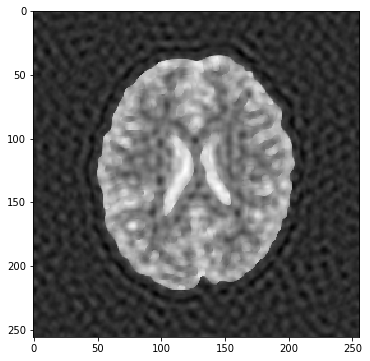

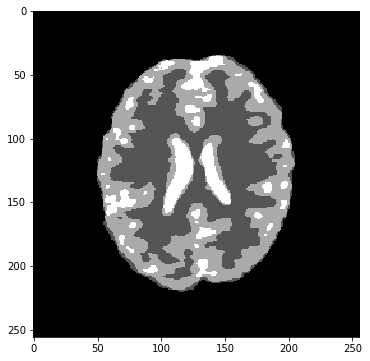

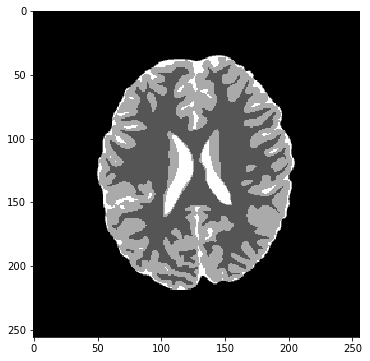

In [27]:
gt_joint = np.real(gt_joint.reshape(gt.shape))
vcl = np.real(vcl.reshape(gt.shape))

plt.figure(figsize=(6, 6))
plt.imshow(gt_joint, 'gray')

plt.figure(figsize=(6, 6))
plt.imshow(vcl, 'gray')

plt.figure(figsize=(6, 6))
plt.imshow(gt_seg, 'gray');

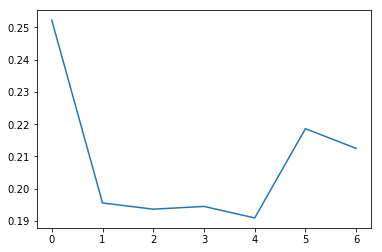

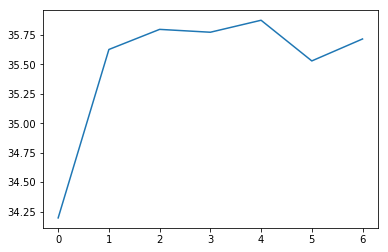

In [28]:
plt.figure()
plt.plot(rre)

plt.figure()
plt.plot(psnr)